# Object detection

Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, “Rapid Object Detection using a Boosted Cascade of Simple Features” in 2001. For that reason it's also well known as the Viola-Jones classifier. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images.

The algorithm needs a lot of positive images (images that contain the object) and negative images (images without the object) to train the classifier. Then we need to extract features from it. For this, haar features shown in below image are used. Each feature is a single value obtained by subtracting sum of pixels under white rectangle from sum of pixels under black rectangle.
![](https://docs.opencv.org/3.0-beta/_images/haar_features.jpg)
But among all these features we calculated, most of them are irrelevant. That is why **Adaboost** is used to select only the best and the most relevant features.

For this, we apply each and every feature on all the training images. For each feature, it finds the best threshold which will classify the objects to positive and negative. But obviously, there will be errors or misclassifications. We select the features with minimum error rate, which means they are the features that best classifies the object and non-object images.

Final classifier is a weighted sum of these weak classifiers. It is called weak because it alone can’t classify the image, but together with others forms a strong classifier.

These weak classifiers are grouped into a Cascade of Classifiers, where the features are grouped into different stages of classifiers and applied one-by-one. If a window fails the first stage, we immediately discard it. We don’t consider remaining features on it. If it passes, we apply the second stage of features and continue the process. **The window which passes all stages is an object region.**

## Haar-cascade Detection in OpenCV

OpenCV comes with a trainer as well as detector. A short tutorial for training your own cascade to detect custom objects will be posted at the bottom of these lecture notes.

And here we will deal with the actual detection. OpenCV already contains many pre-trained classifiers for face, eyes, smile etc. Those XML files are stored in `opencv/data/haarcascades/` folder (if you downloaded the full OpenCV distribution from the [official website](https://opencv.org/releases.html)). If you didn't some of the XML files will be provided in the Git folder of this lecture.

First we need to load the required XML classifiers. Then load our input image (or video) in grayscale mode.

In [8]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_eye.xml')

img = cv2.imread('harold.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Now we find the faces in the image. If faces are found, it returns the positions of detected faces as Rect(x,y,w,h). Once we get these locations, we can create a ROI for the face and apply eye detection on this ROI (since eyes are always on the face).

For demonstration purposes we will highlight the region where a face was found with a blue rectangle, and then highlight the eyes found in that region with green rectangles:

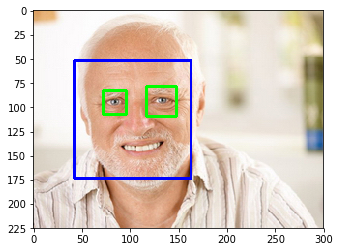

In [9]:
faces = face_cascade.detectMultiScale(gray, 1.1, 5)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## Other feature types for object detection

There are two other widely used types of features, that are often employed for object detection.

The first one is called **LBP** or Local Binary Patterns. Local Binary Pattern is a simple yet very efficient texture operator which labels the pixels of an image by thresholding the neighborhood of each pixel and considers the result as a binary number. Due to its discriminative power and computational simplicity, LBP texture operator has become a popular approach in various applications. Perhaps the most important property of the LBP operator in real-world applications is its robustness to monotonic gray-scale changes caused, for example, by illumination variations. Another important property is its computational simplicity, which makes it possible to analyze images in challenging real-time settings.

The standard OpenCV distribution also comes with several pre-trained LBP-cascades, that are stored in the `opencv/data/lbpcascades/`folder. These cascades are used exactly the same way as the Haar-cascades, no additional parameters are necessary, because the XML files themselves already contain the necessary information about the types of features that are used:

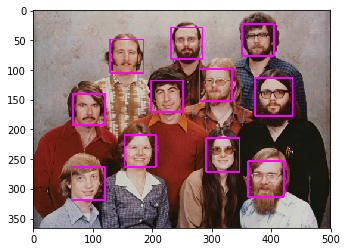

In [10]:
img = cv2.imread("microsoft.jpg")

lbp_face_cascade = cv2.CascadeClassifier('lbpcascades/lbpcascade_frontalface.xml')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = lbp_face_cascade.detectMultiScale(gray, 1.1, 5)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,255),2)    

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

The second one is known as **HOG** (Histogram of Oriented Gradients) and is by far one of the most accurate (as well as most computation heavy) feature types. To compute the HOG descriptor, we operate on 8x8 pixel cells within the detection window. These cells will be organized into overlapping blocks. Within a cell, we compute the gradient vector at each pixel. We take the 64 gradient vectors (in our 8x8 pixel cell) and put them into a 9-bin histogram. The Histogram ranges from 0 to 180 degrees, so there are 20 degrees per bin. For each gradient vector, it’s contribution to the histogram is given by the magnitude of the vector and split the contribution between the two closest bins. The next step in computing the descriptors is to normalize the histograms. 

Unfortunately, training your pwn HOG destriptor in OpenCV became impossible since version 3.0.0, but OpenCV still includes a pedestrian detector that uses the HOG descriptor:

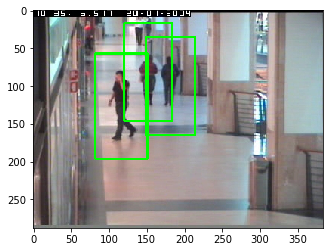

In [16]:
img = cv2.imread("people.jpg")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# create the HOG detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

(rects, weights) = hog.detectMultiScale(gray, winStride=(1,1), scale=1.05)
for (x,y,w,h) in rects:
    cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)
    
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Image segmentation and contours

We have already talked a little about image segmentation in the previous lectures.

Generally speaking, image segmentation fall down to separating a region of an image, where some sort of object is located, from the rest of the image, i.e. separating **foreground** from **background**.

The easiest way to do that is using colour segmentation.

There are two ways of performing colour segmentation in OpenCV. The first one is using a thresholding function (see [lecture 1](http://nbviewer.jupyter.org/urls/dl.dropboxusercontent.com/s/6by8n22jqk2lyrn/Day_1_Image_processing_basics.ipynb)). The second one is using the `cv2.inRange` function.

The latter works similarly to the thresholding function, but instead of using one threshold value it requires two thresholds: a **lower bound** and an **upper bound**. Every pixel, that has a colour value between these two bounds, will be set to 1, while the other pixels will be set to 0. The easiest way to perform colous segmentation is using the HSV colourspace. See example below:

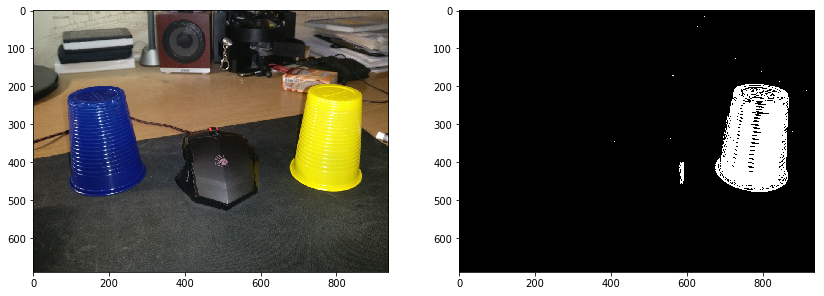

In [53]:
cups = cv2.imread("two_cups.jpg")

hsv = cv2.cvtColor(cups, cv2.COLOR_BGR2HSV)

lowerbound = (20, 175, 0)
upperbound = (32, 250, 255)
mask = cv2.inRange(hsv, lowerbound, upperbound)

plt.subplots(figsize=(14, 10))
plt.subplot(121), plt.imshow(cv2.cvtColor(cups, cv2.COLOR_BGR2RGB))
plt.subplot(122), plt.imshow(mask, cmap='gray')
plt.show()

### Finding the perfect thresholds for segmentation

But how to find the ideal values for the lower and upper bounds? The easiest way to do that is using histograms.
A histogram will show us, how many times every colour is used in the image, which means that we can use a histogram to find out which colour values we need to perform the segmentation.

To build the histogram we can use the `cv2.calcHist` function. This function will give us a one-dimensional array, where the indexes are the colours and the values are the number of times this colour is found in the image. 

<center>`cv2.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]])`</center>

* `images` : it is the source image of type uint8 or float32. it should be given in square brackets, ie, “[img]”.
* `channels` : it is also given in square brackets. It is the index of channel for which we calculate histogram. For example, if input is grayscale image, its value is [0]. For color image, you can pass [0], [1] or [2] to calculate histogram of blue, green or red channel respectively.
* `mask` : mask image. To find histogram of full image, it is given as “None”. But if you want to find histogram of particular region of image, you have to create a mask image for that and give it as mask. (I will show an example later.)
* `histSize` : this represents our BIN count. Need to be given in square brackets. For full scale, we pass [256].
* `ranges` : this is our RANGE. Normally, it is [0,256].

We can then find the maximum value in that array and use it to perform colour segmentation:

In [24]:
img = cv2.imread("only_cup.jpg")

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

hue_hist = cv2.calcHist([hsv],[0],None,[180],[0,180])
sat_hist = cv2.calcHist([hsv],[1],None,[256],[0,256])
val_hist = cv2.calcHist([hsv],[2],None,[256],[0,256])

max_hue = np.argmax(hue_hist)
max_sat = np.argmax(sat_hist)
max_val = np.argmax(val_hist)

print "Maximum Hue value:", max_hue, "Maximum Saturation:", max_sat, "Maximum intensity:", max_val

Maximum Hue value: 29 Maximum Saturation: 244 Maximum intensity: 252


These three values effectively represent the actual HSV values for the yellow colour, that constitutes the palstic yellow cup on the image. We can now construct the upper and lower bounds for our `inRange` function by taking values that are slightly higher and slightly lower than the calculated histogram values respectively.

To get a better idea about the histogram we've just calculated we can try to display these histograms. We can use the `hist` function from the **matplotlib** package:

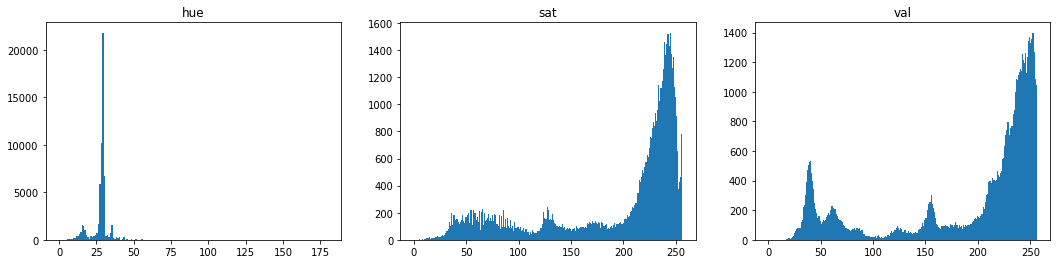

In [28]:
plt.subplots(figsize=(18, 4))
plt.subplot(131), plt.hist(hsv[:,:,0].ravel(),180,[0,180]), plt.title("hue")
plt.subplot(132), plt.hist(hsv[:,:,1].ravel(),256,[0,256]), plt.title("sat")
plt.subplot(133), plt.hist(hsv[:,:,2].ravel(),256,[0,256]), plt.title("val")
plt.show()

### Cleaning up the segmented blob

After performing the colous segmentation it might be a good idea to clean up the binary mask. For that we can use the morphological operations that we've studied earlier:

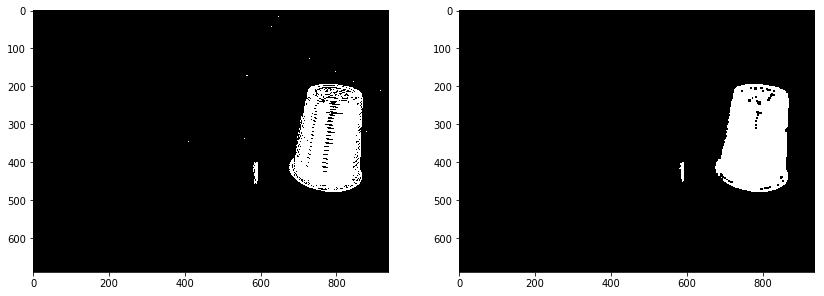

In [36]:
kernel = np.ones((3,3), np.uint8)

# use opening to remove the white specks (noise)
clean_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
# use closing to fill up tears. Bettwe use a bigger kernel size
clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))

plt.subplots(figsize=(14, 10))
plt.subplot(121), plt.imshow(mask, cmap='gray')
plt.subplot(122), plt.imshow(clean_mask, cmap='gray')
plt.show()

We now have two distincs **blobs** on our binary mask. Now is the good time to perform some contour analysis to find out which of these two blobs is the object that we're looking for.

## Contour analysis

Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition.

OpenCV uses the `findContours` function to find contours. Be warned that this function will modify the input image, so it's a good idea to create a backup by copying it.

There are three arguments in `cv2.findContours()` function, first one is **source image**, second is contour **retrieval mode**, third is contour **approximation method**. And it outputs the contours and hierarchy. contours is a Python list of all the contours in the image. Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.

Let's find contours in out binary mask:

In [41]:
mask_copy = clean_mask

mask_copy,contours,hierarchy = cv2.findContours(mask_copy,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

Now the `contours` variable contains a list of all the contours in the image. We can use the `drawContours` function to actually draw the contours on an image:

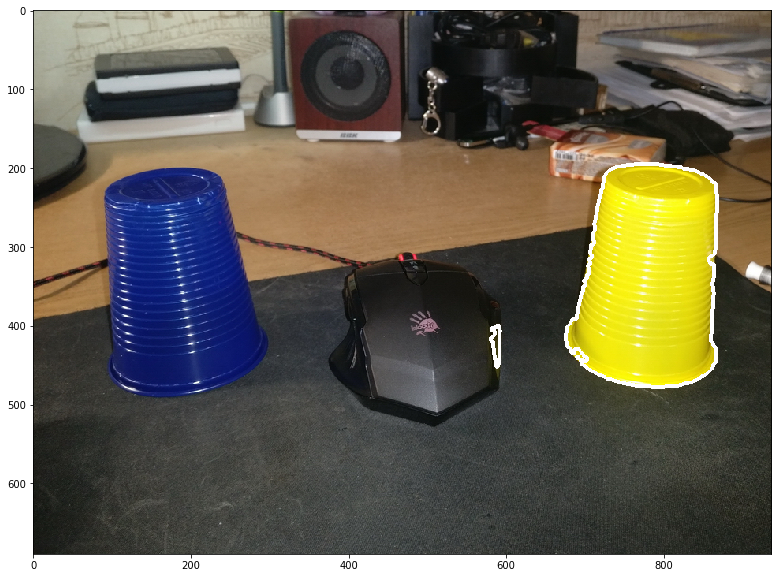

In [51]:
image = np.copy(cups)

for i in range(len(contours)):
    cv2.drawContours(image, contours, i, (255,255,255), 3)

plt.subplots(figsize=(14, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

### Calculating the bounding box for the contour

The easiest thing to do with the contour is to calculate a bounding box that encompasses all the points that describe the contour. The function that does that is called `cv2.boundingRect`. We can use it to draw rectangles on the original image or crop the regions of interest for later use:

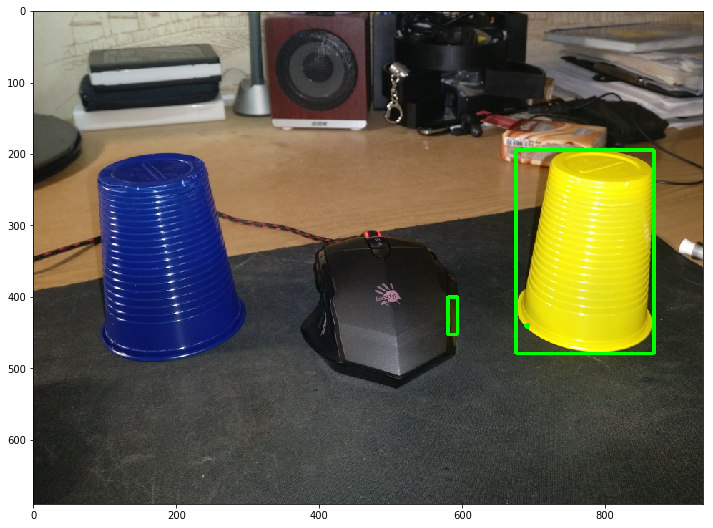

In [62]:
image = np.copy(cups)

for i in range(len(contours)):
    x,y,w,h = cv2.boundingRect(contours[i])
    crop = image[y:y+h, x:x+w]
    cv2.imwrite("crop_" + str(i) + ".jpg", crop)
    
    cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 3)

plt.subplots(figsize=(12, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

### Working with the contours: contour size

Now that we have a pretty good idea about where all the **blobs** are located in the image, we can work with these contours.

The first thing we can do is calculate the total area of the contours, i.e. the number of pixels contained in the polygon described by the points of the contour. This is done using the `contourArea` function. Let's make it so that the contours that are not large enough will simply be ignored:

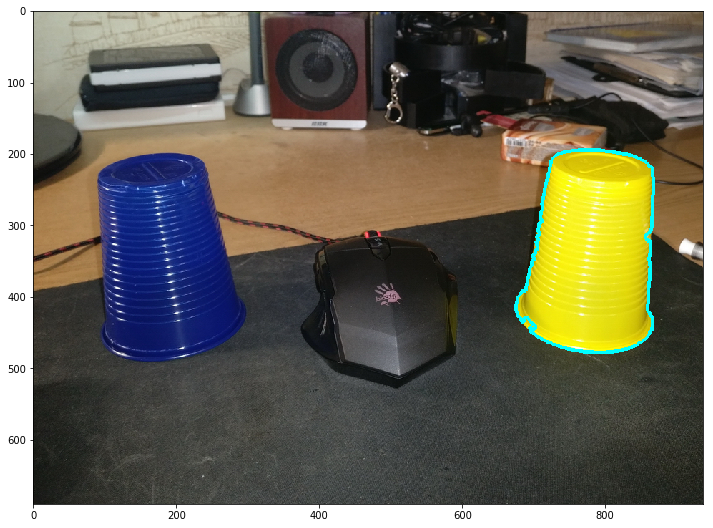

In [54]:
image = np.copy(cups)

for i in range(len(contours)):
    if cv2.contourArea( contours[i] ) > 2000:  
        cv2.drawContours(image, contours, i, (255,255,0), 3)
    else:
        continue

plt.subplots(figsize=(12, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

The `drawContours` function can also be used directly on the mask. For example, we can fill the contours with white colour, to eliminate holes in the blob that are too large for the Morphological Closing to deal with. We can also fill the contour with black colour to completely remove the objects from the mask:

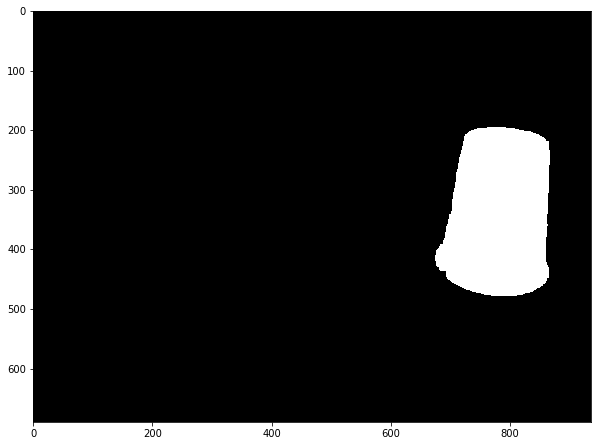

In [68]:
best_mask = np.copy(clean_mask)

for i in range(len(contours)):
    if cv2.contourArea( contours[i] ) > 2000:  
        cv2.drawContours(best_mask, contours, i, 255, -1) # fill with white
    else:
        cv2.drawContours(best_mask, contours, i, 0, -1)   # fill with black

# add some more morphology
best_mask = cv2.morphologyEx(best_mask, cv2.MORPH_CLOSE, np.ones((15,15), np.uint8))        
        
plt.subplots(figsize=(10, 10))
plt.imshow(best_mask, cmap='gray')
plt.show()

It is also possible to quickly calculate the contour perimeter using the `arcLength` function:

In [60]:
for i in range(len(contours)):
    print "contour perimeter:", cv2.arcLength(contours[i], True)

contour perimeter: 8.0
contour perimeter: 127.798989534
contour perimeter: 932.31579566


### Other contour properties

**Contour Moments** help us to calculate some features like center of mass of the object, area of the object etc. Check out the wikipedia page on [Image Moments](http://en.wikipedia.org/wiki/Image_moment).

The function `cv2.moments()` gives us a dictionary of all moment values calculated:

In [69]:
# find the contours again in our 'best mask'
best_mask,contours,hierarchy = cv2.findContours(best_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

cnt = contours[0]
M = cv2.moments(cnt)

From this moments, you can extract useful data like area, centroid etc. Centroid is given by the relations, $C_x = \frac{M_{10}}{M_{00}}$ and $C_y = \frac{M_{01}}{M_{00}}$. This can be done as follows:

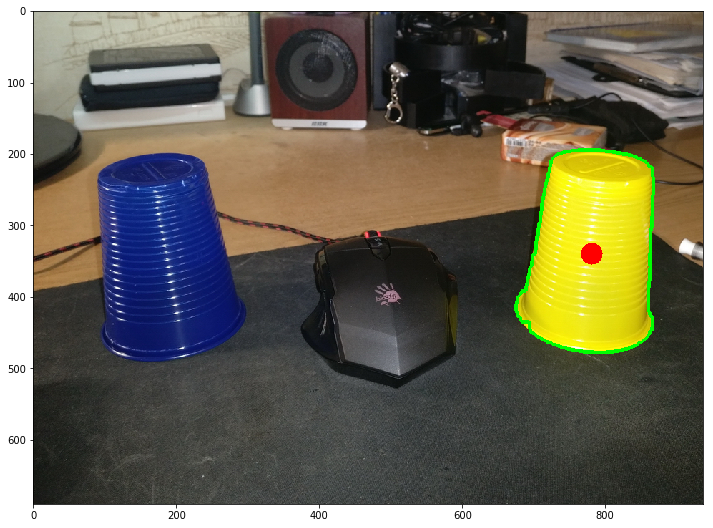

In [73]:
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

# let's show the centroid on the image:
image = np.copy(cups)
cv2.drawContours(image, contours, 0, (0,255,0), 3)
cv2.circle(image, (cx,cy), 15, (0,0,255), -1)

plt.subplots(figsize=(12, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

**Aspect Ratio** is the ratio of width to height of bounding rect of the object.
$$Aspect \; Ratio = \frac{Width}{Height}$$

In [74]:
x,y,w,h = cv2.boundingRect(cnt)
aspect_ratio = float(w)/h

print "Aspect ratio:", aspect_ratio

Aspect ratio: 0.679577464789


**Extent** is the ratio of contour area to bounding rectangle area.
$$Extent = \frac{Object \; Area}{Bounding \; Rectangle \; Area}$$

In [75]:
area = cv2.contourArea(cnt)
x,y,w,h = cv2.boundingRect(cnt)
rect_area = w*h
extent = float(area)/rect_area

print "Extent:", extent

Extent: 0.799177187477


**Orientation** is the angle at which object is directed. Following method also gives the Major Axis and Minor Axis lengths. This feature can sometimes be very useful for object detection to get our bearings and to find out how the object is located relative to the camera and to the other objects:

In [76]:
(x,y),(MA,ma),angle = cv2.fitEllipse(cnt)

**Mean Color or Mean Intensity**

Here, we can find the average color of an object. Or it can be average intensity of the object in grayscale mode. We again use the same mask to do it.

In [80]:
mean_val = cv2.mean(image, mask = best_mask)

print "Mean colour value:",mean_val

Mean colour value: (23.380417081335384, 223.00897946258937, 221.952750384511, 0.0)


**Extreme Points** means topmost, bottommost, rightmost and leftmost points of the object:

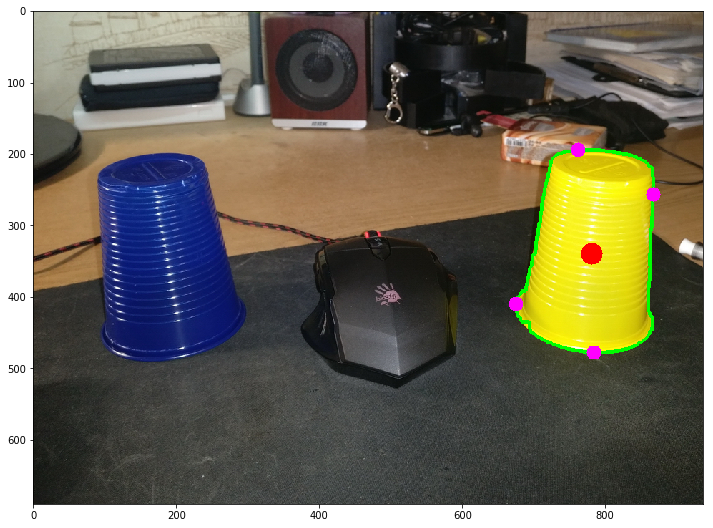

In [82]:
leftmost = tuple(cnt[cnt[:,:,0].argmin()][0])
rightmost = tuple(cnt[cnt[:,:,0].argmax()][0])
topmost = tuple(cnt[cnt[:,:,1].argmin()][0])
bottommost = tuple(cnt[cnt[:,:,1].argmax()][0])

points = [leftmost, rightmost, topmost, bottommost]

for x,y in points:
    cv2.circle(image, (x,y), 10, (255,0,255), -1)
    
plt.subplots(figsize=(12, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show() 

The detailed description of some of the other contour features can be found [here](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_contours/py_contour_properties/py_contour_properties.html).

# Training a Cascade Classifier

To train a Viola-Jones cascade classifier we need as many **positive samples** (images that contain the object that we want to learn to detect) as possible and at least twice as many **negative samples** (images that DO NOT contain the object in question).

The standard OpenCV distribution comes with the utilities for Cascade Training, which can be found in the `opencv\build\_platform_\__compiler__\bin` folder. We are only interested in the `opencv_createsamples.exe` and the `opencv_traincascade.exe` applications.

The first one is used to prepare the positive samples for training, and the second one is needed for the actual training process.

## Positive samples

We need to prepare as many positive samples as possible. It is important to remember, that all the samples should show the object in question from more or less the same perspective. It is foolish to expect that, if we are training a cascade to recognize human faces, we can just use pictures of faces taken from different angles.

The best way to prepare the positive samples is to provide images that contain ONLY the object in question and nothing else:
![](https://clip2net.com/clip/m73955/34fea-clip-270kb.jpg)
We put all the pictures into a separate folder and then prepare a text file that contains the description for all the images, using the following format:

Here the **1** is the number of objects contained in the picture. The following four numbers are the rectangle like `(X, Y, Width, Height)` that contains the actual object. Here's an example of what this `files.dat` file can look like:

Let's save this file as **files.dat** and use is to create the training data. To do that we need to use the `opencv_createsamples.exe` application:

Here the **-vec** parameters sets up the name of the file, where the training data will be saved. The **-w**, **-h** parameters are the width and the height of the training samples. All the samples will be resized to these proportions. The las **-num** parameter is the number of positive samples:
![](https://clip2net.com/clip/m73955/991ce-clip-45kb.png?nocache=1)

## Negative samples

Negative samples are pictures that do not contain the objects in question. We need to have at least twice or three times as many negative samples as there are positive ones for the training to be successful.

Put the samples into a separate folder (e.g. `bg/`):
![](https://clip2net.com/clip/m73955/67bd0-clip-232kb.jpg?nocache=1)

Create a text file that lists all the negative sample files. Example of the `bglist.txt` file:

## Training the cascade

Now all we have to do is fire up the `opencv_traincascade.exe` app to start the training:

Here the **-data** parameter simply specifies the name of the folder where our XML file will be saved. The **-vec** parameter is the name of the training data file that we created earlier, while the **-bg** is the file with the list of negative samples. **-featureType** is the feature type, which can be `HAAR` or `LBP`.

Depending on the number of the training samples you have the training might take from a couple of minutes and up to a whole day, or even more. For example, it took us almost 9 hours to train the HAAR-feature cascade using 1000 positive and 3000 negative samples.